### Boosting 알고리즘 중 가장 대표적인 Xgboost, LightGBM

## 3-2. Xgboost
- XgBoost의 주요 장점
- 1) 뛰어난 예측 성능
- 2) GBM에 대비해, 수행 시간이 적고 과적합 규제 기능이 있음.(과적합 규제 파라미터가 훨씬 다양해짐!)
- 3) tree pruning 가능
- 4) 자체 내장된 교차검증 - 중간에 최적화된다면 조기중단 기능도 있음-->이것이 수행시간을 줄여줌!
- 5) 결손값 자체 처리

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
print(xgb.__version__)

0.90


### 1)파이썬 래퍼 xgboost 적용 - 위스콘신 유방암 예측
- 파이썬 래퍼 xgboost에서 제공하는 여러 하이퍼 파라미터들을 튜닝해 최적의 ML 모델을 만드는 게 목표!

In [3]:
import xgboost as xgb
import pandas as pd
import numpy as np

from xgboost import plot_importance #피처별 중요도

from sklearn.datasets import load_breast_cancer #사이킷런의 이 데이터 활용
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [4]:
cancer = load_breast_cancer()

X_features = cancer.data
y_label = cancer.target

In [7]:
#현황확인을 위해 df 생성(그냥 보기 위해서만 하는 것임)
df = pd.DataFrame(X_features, columns = cancer.feature_names)
df['label'] = y_label
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [6]:
cancer.target_names

array(['malignant', 'benign'], dtype='<U9')

In [8]:
#불균형한 데이터인지 확인
df['label'].value_counts()

1    357
0    212
Name: label, dtype: int64

In [9]:
#trian/test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label , test_size=.2, random_state=156)

print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [11]:
X_train

array([[1.546e+01, 1.189e+01, 1.025e+02, ..., 1.827e-01, 3.216e-01,
        1.010e-01],
       [1.175e+01, 2.018e+01, 7.610e+01, ..., 7.909e-02, 3.168e-01,
        7.987e-02],
       [1.108e+01, 1.471e+01, 7.021e+01, ..., 4.306e-02, 1.902e-01,
        7.313e-02],
       ...,
       [1.245e+01, 1.641e+01, 8.285e+01, ..., 1.342e-01, 3.231e-01,
        1.034e-01],
       [1.270e+01, 1.217e+01, 8.088e+01, ..., 8.224e-02, 2.775e-01,
        9.464e-02],
       [1.016e+01, 1.959e+01, 6.473e+01, ..., 2.232e-02, 2.262e-01,
        6.742e-02]])

In [10]:
#xgb만의 DMatrix 사용: DMatrix(data, label)
#주의) 넘파이만 입력가능. 위에서 split한 값(array니까 넘파이) 아니고 dataframe이면 .values 해서 넣어야함!

#train셋
dtrain = xgb.DMatrix(data=X_train, label = y_train)
#test셋
dtest = xgb.DMatrix(data = X_test, label = y_test)

##### 본격 xgb ML 모델 학습!
###### xgb.train(parameter, dtrain, num_boost_round(=n_estimators), evals(평가할 데이터셋))

In [12]:
#1) 하이퍼파라미터 설정 - 딕셔너리 형태로
params = {'max_depth':3, 'eta':0.1, 'objective':'binary:logistic', 'eval_metric':'logloss', 'early_stoppings':100}
num_rounds = 400 
##약한 학습기는 400개이고 학습 시마다 평가를 하면서 만약 더이상 효율이 안 난다면 early_stoppings에 지정한 만큼까지만 수행 후 조기중단
#여기서는 성능이 저조해질 때, 그 이후로 100번을 지켜보다가 성능 평가가 더이상 효율이 안 난다면 조기중단.

- 조기중단 = "학습"을 조기 중단
- 모델 학습 시, xgboost는 자체 cv 기능이 있어서, eval 셋을 설정하면 train셋을 학습하면서~eval셋으로 평가까지 한다.
- --> 밑에 나오는 긴 리스트들이 바로 그 값. 오류값을 나타내는 것으로, 학습을 많이 진행할수록 값이 줄어든다.

In [14]:
#2)조기 중단 기능을 설정하고 싶다면: 반드시 eval_set(평가할 데이터셋), eval_metric(평가지표)를 명시!
wlist = [(dtrain, 'train'), (dtest,'eval')] #dtest셋은 evaluation 셋

#3)모델 학습-> xgb.train() //train을 시키면서 평가는 위에 설정한대로 dtest셋으로 평가.
xgb_model = xgb.train(params, dtrain, num_boost_round= num_rounds, evals=wlist)

[0]	train-logloss:0.609688	eval-logloss:0.61352
[1]	train-logloss:0.540803	eval-logloss:0.547842
[2]	train-logloss:0.483753	eval-logloss:0.494247
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logloss:0.133985	eval-logloss:0.181818
[18]	train-logloss:0.125599	eval-logloss:0.174729
[19]	train-logloss:0.117286	eval-logloss:0.167657
[20]	train-logl

[164]	train-logloss:0.0072	eval-logloss:0.087777
[165]	train-logloss:0.00718	eval-logloss:0.087517
[166]	train-logloss:0.007161	eval-logloss:0.087542
[167]	train-logloss:0.007142	eval-logloss:0.087642
[168]	train-logloss:0.007122	eval-logloss:0.08739
[169]	train-logloss:0.007103	eval-logloss:0.087377
[170]	train-logloss:0.007084	eval-logloss:0.087298
[171]	train-logloss:0.007065	eval-logloss:0.087368
[172]	train-logloss:0.007047	eval-logloss:0.087395
[173]	train-logloss:0.007028	eval-logloss:0.087385
[174]	train-logloss:0.007009	eval-logloss:0.087132
[175]	train-logloss:0.006991	eval-logloss:0.087159
[176]	train-logloss:0.006973	eval-logloss:0.086955
[177]	train-logloss:0.006955	eval-logloss:0.087053
[178]	train-logloss:0.006937	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.086973
[180]	train-logloss:0.006901	eval-logloss:0.087038
[181]	train-logloss:0.006884	eval-logloss:0.086799
[182]	train-logloss:0.006866	eval-logloss:0.086826
[183]	train-logloss:0.006849	eval-log

[326]	train-logloss:0.005354	eval-logloss:0.08578
[327]	train-logloss:0.005348	eval-logloss:0.085857
[328]	train-logloss:0.005342	eval-logloss:0.085939
[329]	train-logloss:0.005336	eval-logloss:0.085825
[330]	train-logloss:0.00533	eval-logloss:0.085869
[331]	train-logloss:0.005324	eval-logloss:0.085893
[332]	train-logloss:0.005318	eval-logloss:0.085922
[333]	train-logloss:0.005312	eval-logloss:0.085842
[334]	train-logloss:0.005306	eval-logloss:0.085735
[335]	train-logloss:0.0053	eval-logloss:0.085816
[336]	train-logloss:0.005294	eval-logloss:0.085892
[337]	train-logloss:0.005288	eval-logloss:0.085936
[338]	train-logloss:0.005283	eval-logloss:0.08583
[339]	train-logloss:0.005277	eval-logloss:0.085909
[340]	train-logloss:0.005271	eval-logloss:0.085831
[341]	train-logloss:0.005265	eval-logloss:0.085727
[342]	train-logloss:0.00526	eval-logloss:0.085678
[343]	train-logloss:0.005254	eval-logloss:0.085721
[344]	train-logloss:0.005249	eval-logloss:0.085796
[345]	train-logloss:0.005243	eval-log

In [18]:
#4)예측-> 모델.predict() :근데 예측 결과는 label값이 아닌, 확률값임-나중에 코드 추가 필요
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10],3)) #여기선 round() 함수는 못씀(왜냐면 반환하는게 ndarray라서 np.round만 가능)

[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]


In [20]:
preds = [1 if x>0.5 else 0 for x in pred_probs] #확률값이 0.5보다 크면 1 반환
preds[:10]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]

In [1]:
a = [12, 32, 323, 338, 102]

In [2]:
pred = [1 if x>100 else 0 for x in a]
pred

[0, 0, 1, 1, 1]

In [26]:
#5)평가
#평가할 경우, score( y_test, preds )
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(confusion_matrix(y_test,preds))
print(round(accuracy_score(y_test,preds),3))
print(round(precision_score(y_test,preds),3))
print(round(recall_score(y_test,preds),3))
print(round(f1_score(y_test,preds),3))
print(round(roc_auc_score(y_test,preds),3))

[[35  2]
 [ 1 76]]
0.974
0.974
0.987
0.981
0.966


##### plot_importance(모델명, ax) :  x축-모델의 f1 score
- 문제: 숫자형만 반환하므로 피처명이 안나옴.(피처명은 몇번째 피처인지만 나옴..)
- 항상 앞에 fig, ax로 subplots 설정!

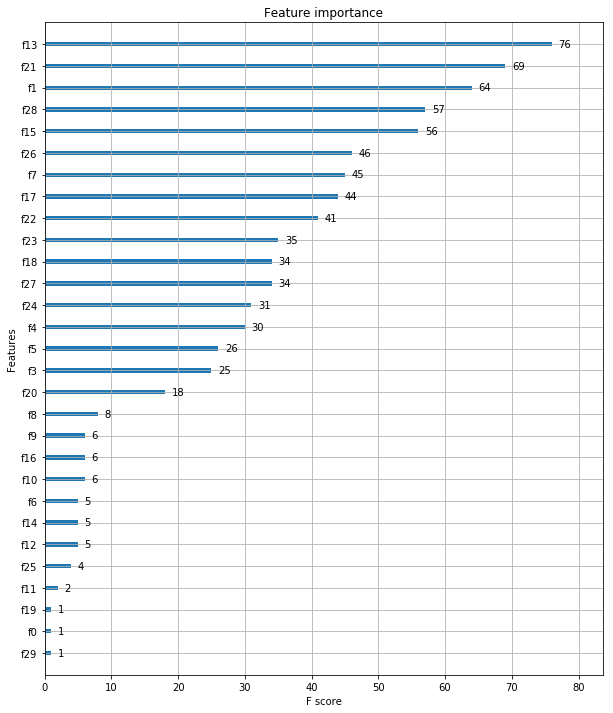

In [28]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax)

### 앞으로는 이걸 사용!
### 2)사이킷런 래퍼 xgboost 적용 - 위스콘신 유방암 예측
- 사이킷런 래퍼 xgboost에서 제공하는 여러 하이퍼 파라미터들을 튜닝해 최적의 ML 모델을 만드는 게 목표!
- 우리가 지금껏 사용해오던 코드와 같아서 더 친숙.

In [30]:
from xgboost import XGBClassifier

###### XGBClassifier(n_estimators, learning_rate, max_depth)

In [38]:
#객체
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate = 0.1, max_depth=3)
#학습
xgb_wrapper.fit(X_train, y_train)
#예측
preds = xgb_wrapper.predict(X_test)

In [39]:
#평가
print(confusion_matrix(y_test,preds))
print(round(accuracy_score(y_test,preds),3))
print(round(precision_score(y_test,preds),3))
print(round(recall_score(y_test,preds),3))
print(round(f1_score(y_test,preds),3))
print(round(roc_auc_score(y_test,preds),3))

##결과는 파이썬 래퍼로 하든 사이킷런 래퍼로 하든 동일!

[[35  2]
 [ 1 76]]
0.974
0.974
0.987
0.981
0.966


- 조기중단 파라미터를 넣고싶다면 -> 모델.fit() 메서드 안에! : early_stopping_rounds/ eval_metric/ eval_set 
- 조기중단 = "학습"을 조기 중단한다.

In [33]:
#객체
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate = 0.1, max_depth=3)
#학습(여기에!!)
evals = [(X_test, y_test)] ##여기서는 test셋을 평가 셋으로 넣음.(근데 바람직하진 않고, 실전에서 사용시엔 train/test셋 외에 안알려진 데이터셋 총 3개를 준비!)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals)
#예측
w_preds = xgb_wrapper.predict(X_test) #311번에서 조기중단(이유: 211번이 가장 낮았고 311번까지 더 이상 값이 떨어지지 않아서)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

[230]	validation_0-logloss:0.086002
[231]	validation_0-logloss:0.085922
[232]	validation_0-logloss:0.086102
[233]	validation_0-logloss:0.086115
[234]	validation_0-logloss:0.086169
[235]	validation_0-logloss:0.086263
[236]	validation_0-logloss:0.086292
[237]	validation_0-logloss:0.086217
[238]	validation_0-logloss:0.086395
[239]	validation_0-logloss:0.086342
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.086195
[242]	validation_0-logloss:0.086248
[243]	validation_0-logloss:0.086263
[244]	validation_0-logloss:0.086293
[245]	validation_0-logloss:0.086222
[246]	validation_0-logloss:0.086398
[247]	validation_0-logloss:0.086347
[248]	validation_0-logloss:0.086276
[249]	validation_0-logloss:0.086448
[250]	validation_0-logloss:0.086294
[251]	validation_0-logloss:0.086312
[252]	validation_0-logloss:0.086364
[253]	validation_0-logloss:0.086394
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.086441
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08

In [34]:
#평가
print(confusion_matrix(y_test,w_preds))
print(round(accuracy_score(y_test,w_preds),3))
print(round(precision_score(y_test,w_preds),3))
print(round(recall_score(y_test,w_preds),3))
print(round(f1_score(y_test,w_preds),3))
print(round(roc_auc_score(y_test,w_preds),3))

##결과는 아까 조기중단 하지 않았을 때보다 떨어지지만 큰 차이는 아님.(시간 면에서 이게 더 좋음)

[[34  3]
 [ 1 76]]
0.965
0.962
0.987
0.974
0.953


- 조기 중단 값을(early_stopping_rounds) 너무 급격하게 줄이면 학습이 제대로 되지 않을 수 있음.(너무 빨리 조기중단해버리니까)

In [35]:
#객체
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate = 0.1, max_depth=3)
#학습(여기에!!)
evals = [(X_test, y_test)] ##조기중단 값 100-> 10 변경
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=evals)
#예측
w_preds = xgb_wrapper.predict(X_test) #62번에서 조기중단(이유: 52번이 가장 낮았고 그 이후로 10번을 지켜보는 동안 값이 더 낮아지지 않아서)

## 하지만 올바른 선택이 아님. 이 데이터는 52번 후 62번까지는 더 높게 나오지만 그 이후로 가면 분명 52번보다 낮은 수치들이 나온다.

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


In [36]:
#평가
print(confusion_matrix(y_test,w_preds))
print(round(accuracy_score(y_test,w_preds),3))
print(round(precision_score(y_test,w_preds),3))
print(round(recall_score(y_test,w_preds),3))
print(round(f1_score(y_test,w_preds),3))
print(round(roc_auc_score(y_test,w_preds),3))

##결과는 아까 조기중단 100 설정 시보다 더 떨어짐

[[34  3]
 [ 2 75]]
0.956
0.962
0.974
0.968
0.946


##### plot_importance(모델, ax) :피처 별 중요도 값 시각화

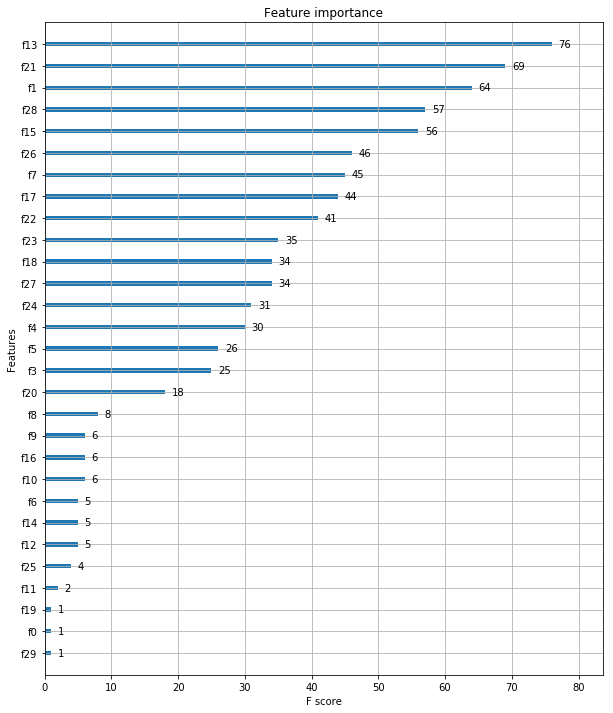

In [40]:
#이거는 아까 한 파이썬 래퍼 방식과 코드 동일
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper, ax) #plot_importance() 안에 그냥 넣으면 됨!! 

## 3-3. LightGBM
- XgBoost에 비한 장점
- 1) 예측 성능은 비슷
- 2) 수행 시간이 적음, 메모리 사용량 적음
- 3) 카테고리형 피처의 자동 변환과 최적 분할

##### 한가지 단점: 
- 데이터가 작으면 과적합 발생 가능.


In [3]:
from lightgbm import LGBMClassifier

In [8]:
#LGBM을 통해 위스콘신 유방암 예측
import pandas  as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
cancer = load_breast_cancer()
ftr = cancer.data
target = cancer.target

##### LGBMClassifier(n_estimator, learning_rate, num_leaves, min_child_samples, max_depth)

In [13]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=.2, random_state=156)

#객체
lgbm_wrapper = LGBMClassifier(n_estimator=400)

#학습(조기중단기능도!)
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True) #verbose를 사용하면 상세한 설명도 함께 출력

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865
[14]	valid_0's binary_logloss: 0.215076
[15]	valid_0's binary_logloss: 0.205996
[16]	valid_0's binary_logloss: 0.196091
[17]	valid_0's binary_logloss: 0.186395
[18]	valid_0's binary_logloss: 0.17942
[19]	valid_0's binary_logloss: 0.174727
[20]	valid_0's binary_logloss: 0.168563
[21]	valid_0's binary_logloss: 0.165432
[22]	valid_0's binary_logloss: 0.160356
[23]	valid_0's binary_logloss: 0.155508
[24]	valid_0's binary_logloss: 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimator=400, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [9]:
#예측
preds = lgbm_wrapper.predict(X_test)
#평가
print(accuracy_score(y_test, preds))

0.9473684210526315


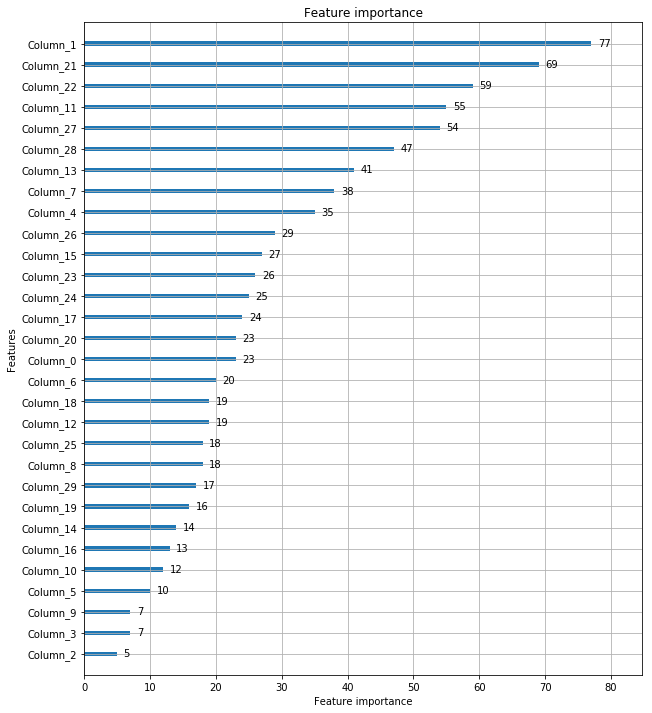

In [10]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax)